# House Pricing Prediction Portfolio - Notebook 3 of 3



After completing the cleaning and EDA steps on the dataset in the "House Pricing Prediction Data Cleaning Notebook" and "House Pricing Prediction EDA Notebook" in the project portfolio.

We will now build couple of models to predict the target variable, identify the model with the best performance and use to produce the final deliverables.

### 1.1 Import Libraries

In [1]:
#Analysis packages
import pandas as pd
import sklearn as sk
import numpy as np
import scipy.stats as sp

#Visualization packages
import matplotlib.pyplot as plt
import matplotlib as matplot
from matplotlib.ticker import MaxNLocator
import seaborn as sns

#Preprocessing
from sklearn import preprocessing

#Models & Sklearn packages
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score as cvs
from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rfregr
from sklearn.ensemble import GradientBoostingRegressor as grbregr
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


#setting directory where python interpreter looks for code files
import sys
sys.path.insert(0, './scripts')

#read in functions from script file
from codes import eda_process, model

from tqdm import tqdm
import datetime

import warnings
warnings.filterwarnings('ignore')
#your info here
__author__ = "Laniya Oladapo"
__email__ = "laniyadapo@gmail.com"

### 1.2 Define Classes

Classes defined in "codes.py" module under script folder in working directory

## Part 3 - Model Development

### 3.1 Load and Prepare Data For Modeling 

In [2]:
#load the data exported from the EDA Notebook into a Pandas dataframe
train_df = pd.read_csv("train_df_forModel.csv")
test_df = pd.read_csv("test_df_forModel.csv")

In [3]:
#Create a copy of data before starting model building process
train_df_init = train_df.copy()
test_df_init = test_df.copy()

3.1.1 Prepare dataframe for modeling

In [4]:
#Create independent features dataframe for modelling
train_df_X = (train_df.drop(['SalePrice'], axis=1)).copy()

In [5]:
#Create dependent feature dataframe for modelling
train_df_Y = train_df.SalePrice

In [6]:
#Extract all categorical feature ready for encoding
train_df_X.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [7]:
train_df_X.select_dtypes(include=['object']).describe()

,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType
count,1454,1454,1454,1454,1454,1454,1454,1454,1454,1454,...,1454,1454,1454,1454,1454,1454,1454,1454,1454,1454
unique,5,2,3,4,4,5,25,9,8,5,...,6,7,4,6,6,3,4,5,5,9
top,RL,Pave,None,Reg,Lvl,Inside,NAmes,Norm,Norm,1Fam,...,None,Attchd,Unf,TA,TA,Y,None,None,None,WD
freq,1145,1449,1363,925,1311,1050,224,1256,1439,1215,...,690,864,604,1305,1320,1334,1448,1173,1402,1262


Most machine learning models can only handle numerical values.

In order to get the data ready for modelling we will transform categorical features into individual binary feature using the dummy variable coding approach. 

In [8]:
#Encode categorical features
cat_variables = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 
                 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 
                 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 
                 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 
                 'Fence', 'MiscFeature', 'SaleType']

for var in cat_variables:
    dummies = pd.get_dummies(train_df_X[var], prefix=var)
    train_df_X = pd.concat([train_df_X, dummies], axis=1)
    train_df_X.drop([var], axis=1, inplace=True)

In [9]:
#Split training data
X_train, X_test, y_train, y_test = train_test_split(train_df_X, train_df_Y, test_size=0.20, random_state=5)

### 3.2 Description of Selected Models

Below are descriptions of selected models and rationale behind selecting them.

1. Ridge and Lasso Regression - powerful techniques for creating parsmonious models in the presence of a 'large' number of features.
2. Random Forest Regressor - improves the accuracy by reducing overfitting problem and the variance in decision trees.
3. GradientBoostingRegressor - typically produces best predictions because it can optimize on different loss functions and provides several hyperparameter tuning options that make the function fit very flexible.

3.2.1 First step is to create the models using default parameters.

In [10]:
# create models
models_eval = []
#models_eval.append(('LinearRegression', lr()))
models_eval.append(('Lasso', Lasso(alpha=0.0005, random_state=5)))
models_eval.append(('RandomForest', rfregr(random_state=5)))
models_eval.append(('GradientBoosting', grbregr(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=5)))
models_eval.append(('Ridge', Ridge(alpha=0.002, random_state=5)))
                   
print(models_eval)

[('Lasso', Lasso(alpha=0.0005, random_state=5)), ('RandomForest', RandomForestRegressor(random_state=5)), ('GradientBoosting', GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
                          random_state=5)), ('Ridge', Ridge(alpha=0.002, random_state=5))]


3.2.2 Evaluate the selected models using MAE metric

Lasso: 19492.355820
RandomForest: 15593.195292
GradientBoosting: 14474.336273
Ridge: 20344.994315


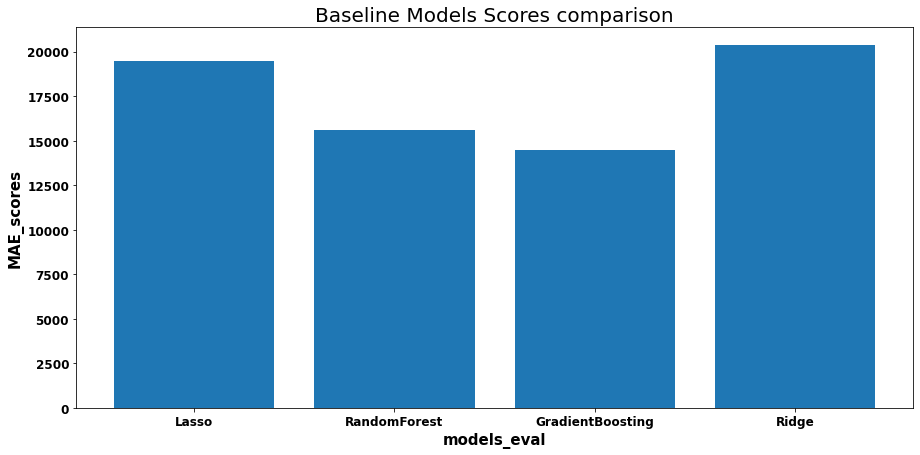

In [11]:
#Evaluate baseline models with default parameters
model_run1 = model(X_train, X_test, y_train, y_test)
model_run1.model_run(models_eval, 'Baseline')

With a baseline mean absolute error established for each model, our next task is to improve the scores and select the best model.

Considering the baseline model predictions are based on data provided without extensive feature generation or model tuning we will perform some feature engineering and cross validation to improve the scores before selecting the best model.

The SalePrice prediction expected output is a continuous value hence we will use from the suite of regression supervised learning algorithms. 

### 3.3 Feature Engineering 

3.3.1 Create dataframe for independent features

In [12]:
#Create independent features dataframe for modelling
train_df1_X = (train_df.drop(['SalePrice'], axis=1)).copy()

3.3.2 Perform feature engineering on data to improve model performance

In [13]:
#Create dataframe for log transformed target variable
train_df_logY = np.log(train_df['SalePrice'])

In [14]:
#Convert some features to string datatype based on their description
#train_df1_X['OverallQual'] = train_df1_X['OverallQual'].astype(str)
#train_df1_X['OverallCond'] = train_df1_X['OverallCond'].astype(str)
train_df1_X['MSSubClass'] = train_df1_X['MSSubClass'].astype(str)

In [15]:
# Converting some of the categorical values to numeric ones. Choosing similar values for closer groups to balance linear relations...

hood_map = {'MeadowV': 1, 'IDOTRR': 1, 'BrDale': 1, 'BrkSide': 2, 'OldTown': 2, 'Edwards': 2, 'Sawyer': 3, 'Blueste': 3, 
            'SWISU': 3, 'NPkVill': 3, 'NAmes': 3, 'Mitchel': 4, 'SawyerW': 5, 'NWAmes': 5, 'Gilbert': 5, 'Blmngtn': 5, 
            'CollgCr': 5, 'ClearCr': 6, 'Crawfor': 6, 'Veenker': 7, 'Somerst': 7, 'Timber': 8, 'StoneBr': 9, 'NridgHt': 10, 
            'NoRidge': 10}
train_df1_X['Neighborhood'] = train_df1_X['Neighborhood'].map(hood_map).astype('int')

exterior_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
train_df1_X['ExterQual'] = train_df1_X['ExterQual'].map(exterior_map).astype('int')
train_df1_X['ExterCond'] = train_df1_X['ExterCond'].map(exterior_map).astype('int')

bsmt_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
train_df1_X['BsmtQual'] = train_df1_X['BsmtQual'].map(bsmt_map).astype('int')
train_df1_X['FireplaceQu'] = train_df1_X['FireplaceQu'].map(bsmt_map).astype('int')
train_df1_X['GarageCond'] = train_df1_X['GarageCond'].map(bsmt_map).astype('int')
train_df1_X['GarageQual'] = train_df1_X['GarageQual'].map(bsmt_map).astype('int')
train_df1_X['BsmtCond'] = train_df1_X['BsmtCond'].map(bsmt_map).astype('int')

bsmtf_map = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
train_df1_X['BsmtFinType1'] = train_df1_X['BsmtFinType1'].map(bsmtf_map).astype('int')
train_df1_X['BsmtFinType2'] = train_df1_X['BsmtFinType2'].map(bsmtf_map).astype('int')

misc_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
train_df1_X['HeatingQC'] = train_df1_X['HeatingQC'].map(misc_map).astype('int')
train_df1_X['KitchenQual'] = train_df1_X['KitchenQual'].map(misc_map).astype('int')

gar_map = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3,}
train_df1_X['GarageFinish'] = train_df1_X['GarageFinish'].map(gar_map).astype('int')

bsmtex_map = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
train_df1_X['BsmtExposure'] = train_df1_X['BsmtExposure'].map(bsmtex_map).astype('int')

cair_map = {'N': 0, 'Y': 1,}
train_df1_X['CentralAir'] = train_df1_X['CentralAir'].map(cair_map).astype('int')

paved_map = {'N': 0, 'P': 1, 'Y': 2,}
train_df1_X['PavedDrive'] = train_df1_X['PavedDrive'].map(paved_map).astype('int')

poolqc_map = {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
train_df1_X['PoolQC'] = train_df1_X['PoolQC'].map(poolqc_map).astype('int')

In [16]:
#Create a feature for Age of house using the YearBuilt & YearRemodAdd features and drop YearBuilt, YearRemodAdd, Diff
now = datetime.datetime.now()
train_df1_X['Diff'] = train_df1_X['YearRemodAdd'] - train_df1_X['YearBuilt']

if ((train_df1_X['Diff'] > 0).any()):
    house_age = now.year - train_df1_X['YearRemodAdd']
    train_df1_X['HouseAge'] = now.year - train_df1_X['YearRemodAdd']
else:
    house_age = now.year - train_df1_X['YearBuilt']
    train_df1_X['HouseAge'] = now.year - train_df1_X['YearBuilt']
train_df1_X = train_df1_X.drop(['YearBuilt', 'YearRemodAdd', 'Diff'], axis=1)

In [17]:
#Extract all categorical feature ready for encoding
train_df1_X.select_dtypes(include=['object']).columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'Foundation',
       'Heating', 'Electrical', 'Functional', 'GarageType', 'Fence',
       'MiscFeature', 'SaleType'],
      dtype='object')

In [18]:
#Extract all numerical feature ready for encoding
train_df1_X.select_dtypes(exclude=['object']).columns

Index(['LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'HouseAge'],
      dtype='object')

In [19]:
#Normalize numerical data in Training Dataset ready for modeling
features = ['LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'HouseAge']
train_norm = eda_process(train_df1_X)
train_norm.normalize(features)
train_df1_X = train_df1_X.drop(features, axis=1)
train_df1_X.describe()

,LotFrontagenorm,LotAreanorm,Neighborhoodnorm,OverallQualnorm,OverallCondnorm,MasVnrAreanorm,ExterQualnorm,ExterCondnorm,BsmtQualnorm,BsmtCondnorm,...,GarageQualnorm,GarageCondnorm,PavedDrivenorm,WoodDeckSFnorm,OpenPorchSFnorm,EnclosedPorchnorm,ScreenPorchnorm,PoolAreanorm,PoolQCnorm,HouseAgenorm
count,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,...,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000
mean,0.383446,0.141991,0.449243,0.609560,0.619364,0.064018,0.679092,0.616781,0.697387,0.733666,...,0.561898,0.561623,0.927785,0.109410,0.085103,0.039936,0.031506,0.003306,0.002751,0.502348
std,0.112508,0.077078,0.244688,0.138115,0.123720,0.112344,0.114666,0.070347,0.175377,0.138320,...,0.144857,0.144213,0.248765,0.145094,0.120717,0.110922,0.116383,0.051846,0.047214,0.294935
min,0.115385,0.018372,0.100000,0.100000,0.111111,0.000000,0.400000,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857
25%,0.329670,0.106503,0.300000,0.500000,0.555556,0.000000,0.600000,0.600000,0.600000,0.750000,...,0.600000,0.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.228571
50%,0.384615,0.133668,0.500000,0.600000,0.555556,0.000000,0.600000,0.600000,0.800000,0.750000,...,0.600000,0.600000,1.000000,0.000000,0.045704,0.000000,0.000000,0.000000,0.000000,0.371429
75%,0.439560,0.163173,0.500000,0.700000,0.666667,0.102344,0.800000,0.600000,0.800000,0.750000,...,0.600000,0.600000,1.000000,0.196033,0.124314,0.000000,0.000000,0.000000,0.000000,0.757143
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
#Encode categorical features
cat_variables = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'Foundation',
       'Heating', 'Electrical', 'Functional', 'GarageType', 'Fence',
       'MiscFeature', 'SaleType']

for var in cat_variables:
    dummies = pd.get_dummies(train_df1_X[var], prefix=var)
    train_df1_X = pd.concat([train_df1_X, dummies], axis=1)
    train_df1_X.drop([var], axis=1, inplace=True)
train_df1_X.describe()

,LotFrontagenorm,LotAreanorm,Neighborhoodnorm,OverallQualnorm,OverallCondnorm,MasVnrAreanorm,ExterQualnorm,ExterCondnorm,BsmtQualnorm,BsmtCondnorm,...,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
count,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,...,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000
mean,0.383446,0.141991,0.449243,0.609560,0.619364,0.064018,0.679092,0.616781,0.697387,0.733666,...,0.000688,0.029574,0.002751,0.001376,0.006190,0.003439,0.003439,0.083219,0.002063,0.867950
std,0.112508,0.077078,0.244688,0.138115,0.123720,0.112344,0.114666,0.070347,0.175377,0.138320,...,0.026225,0.169466,0.052396,0.037075,0.078459,0.058560,0.058560,0.276308,0.045392,0.338661
min,0.115385,0.018372,0.100000,0.100000,0.111111,0.000000,0.400000,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.329670,0.106503,0.300000,0.500000,0.555556,0.000000,0.600000,0.600000,0.600000,0.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.384615,0.133668,0.500000,0.600000,0.555556,0.000000,0.600000,0.600000,0.800000,0.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.439560,0.163173,0.500000,0.700000,0.666667,0.102344,0.800000,0.600000,0.800000,0.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
#Split training data
X1_train, X1_test, y1_train, y1_test = train_test_split(train_df1_X, train_df_logY, test_size=0.20, random_state=5)

### 3.4 Models Hyperparameter tuning

3.4.1 Lasso Model Hyperparameter tuning

In [22]:
lasso_params = {'alpha':[1e-3, 1e-2, 1, 2, 5, 7, 10]}

model = GridSearchCV(Lasso(), lasso_params, scoring='neg_mean_absolute_error')
model.fit(X1_train, y1_train)

print(model.best_params_)
print(model.best_score_)

{'alpha': 0.001}
-0.08653662973766947


3.4.2 Ridge Model Hyperparameter tuning

In [23]:
ridge_params = {'alpha':[1e-3, 1e-2, 1, 2, 5, 7, 10, 20, 30, 40]}

model = GridSearchCV(Ridge(), ridge_params, scoring='neg_mean_absolute_error')
model.fit(X1_train, y1_train)

print(model.best_params_)
print(model.best_score_)

{'alpha': 1}
-0.0890593394164932


3.4.3 Random Forest Model Hyperparameter tuning

In [24]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = rfregr(n_estimators = 100, random_state = 42)
base_model.fit(X1_train, y1_train)
base_accuracy = evaluate(base_model, X1_test, y1_test)

Model Performance
Average Error: 0.0898 degrees.
Accuracy = 99.25%.


In [25]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60, 70, 80, 100],
    'max_features': ["auto", None, "sqrt", "log2"],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [10, 20, 30, 40, 50],
    'n_estimators': [400, 600, 800, 1000]
}
# Create a based model
base_rf = rfregr()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = base_rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [26]:
# Fit the grid search to the data
grid_search.fit(X1_train, y1_train)
grid_search.best_params_

Fitting 3 folds for each of 2400 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 70.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 98.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 118.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 152.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 184.7min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 206.9min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 239.0min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 276.6min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 282.3min finished


{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 400}

In [28]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X1_test, y1_test)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.0889 degrees.
Accuracy = 99.25%.
Improvement of 0.01%.


3.4.4 Gradient Boost Model Hyperparameter tuning

In [32]:
def select_params(X1_train, y1_train, X1_test, y1_test, max_estimators=1000, max_depth = 3, learning_rate=0.01, min_samples_leaf=20):

    #feature_train, feature_tune, target_train, target_tune = train_test_split(model_data[features], model_data['salary'], test_size=0.33, random_state=0, shuffle=True)
    
    gbm = grbregr(n_estimators = max_estimators, learning_rate=learning_rate, 
                                    max_depth=max_depth, loss='ls', subsample=1.0, min_samples_leaf=min_samples_leaf)

    gbm.fit(X1_train, y1_train)

    test_score = np.zeros(max_estimators)

    for i, y_pred in enumerate(gbm.staged_predict(X1_test)):
        test_score[i] = mae(y1_test, y_pred)
        
    print('optimal number of trees: {0}'.format(test_score.argmin()))
    print('best MSE: {0}'.format(test_score.min()))
    # print('baseline MAE: {0}'.format(mse(target_tune, target_train.median())))
    pd.Series(test_score).plot(title='learning curve for max_depth = {0}'.format(max_depth))
    plt.show()

***** training for max depth = 6 *****
optimal number of trees: 39
best MSE: 0.08727254507725567


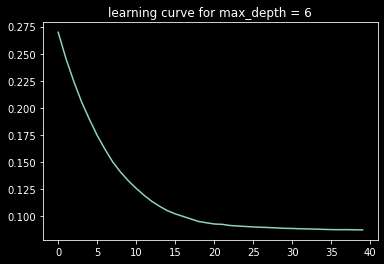

***** training for max depth = 8 *****
optimal number of trees: 36
best MSE: 0.08669379667980764


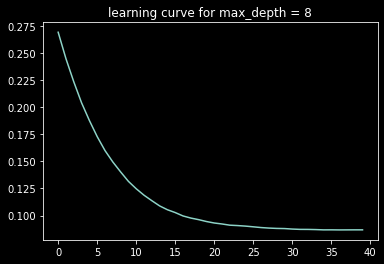

***** training for max depth = 10 *****
optimal number of trees: 32
best MSE: 0.08787874795668779


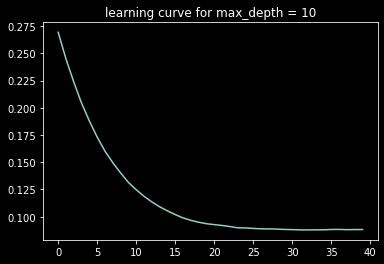

In [35]:
for depth in [6, 8, 10]:
    print('***** training for max depth = {0} *****'.format(depth))
    select_params(X1_train, y1_train, X1_test, y1_test, max_estimators=40, max_depth=depth, learning_rate=0.1)

Max Depth of 8 computes best MAE, next we tune for Max Estimator.

***** training for max estimators = 100 *****
optimal number of trees: 90
best MSE: 0.08658447311251459


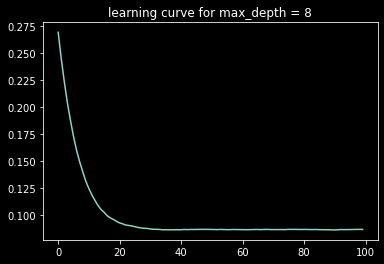

***** training for max estimators = 200 *****
optimal number of trees: 194
best MSE: 0.08644169496259235


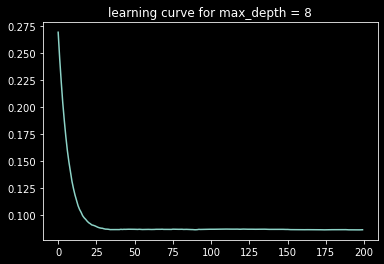

***** training for max estimators = 300 *****
optimal number of trees: 194
best MSE: 0.08641760270280557


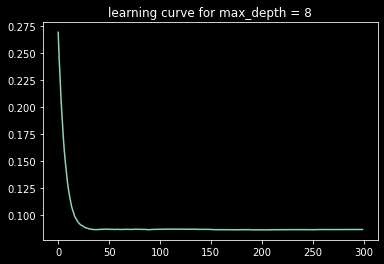

***** training for max estimators = 400 *****
optimal number of trees: 194
best MSE: 0.08643731986771473


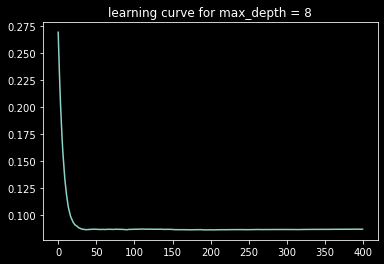

In [39]:
for max_e in [100, 200, 300, 400]:
    print('***** training for max estimators = {0} *****'.format(max_e))
    select_params(X1_train, y1_train, X1_test, y1_test, max_estimators=max_e, max_depth=8, learning_rate=0.1)

Max Estimator of 300 computes best MAE, next we tune for learning rate.

***** training for learning_rate = 0.02 *****
optimal number of trees: 181
best MSE: 0.08516325725030283


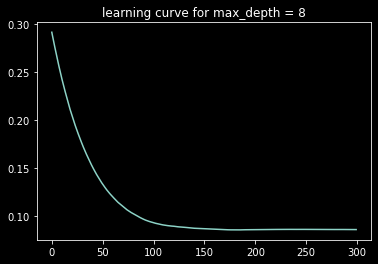

***** training for learning_rate = 0.03 *****
optimal number of trees: 293
best MSE: 0.08445191573272351


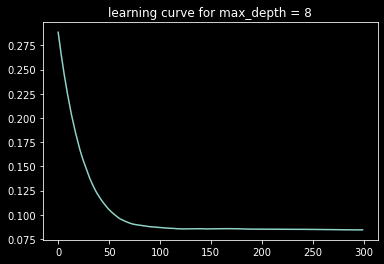

***** training for learning_rate = 0.05 *****
optimal number of trees: 297
best MSE: 0.08386167061592563


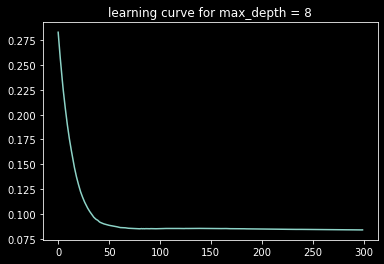

***** training for learning_rate = 0.07 *****
optimal number of trees: 282
best MSE: 0.0847959205412691


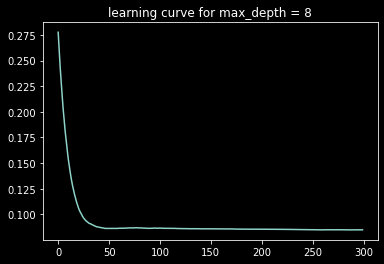

In [42]:
for learn_rate in [0.02, 0.03, 0.05, 0.07]:
    print('***** training for learning_rate = {0} *****'.format(learn_rate))
    select_params(X1_train, y1_train, X1_test, y1_test, max_estimators=300, max_depth=8, learning_rate=learn_rate)

Learning rate of 0.05 computes best MAE.

***** training for min_sample_leaf = 20 *****
optimal number of trees: 297
best MSE: 0.08384178014913865


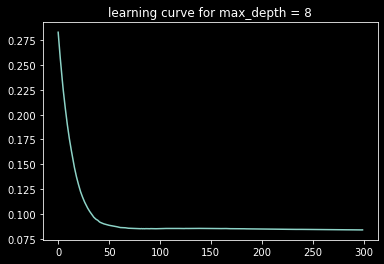

***** training for min_sample_leaf = 22 *****
optimal number of trees: 241
best MSE: 0.08440496931054643


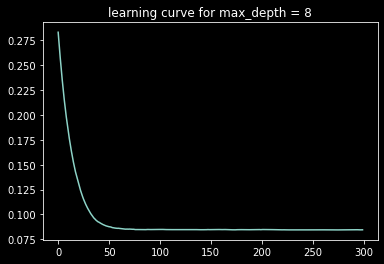

***** training for min_sample_leaf = 24 *****
optimal number of trees: 150
best MSE: 0.08223074498062159


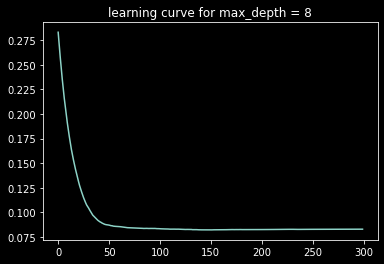

***** training for min_sample_leaf = 26 *****
optimal number of trees: 162
best MSE: 0.08233837779764731


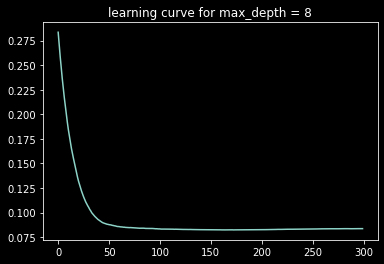

***** training for min_sample_leaf = 28 *****
optimal number of trees: 173
best MSE: 0.0827344437492941


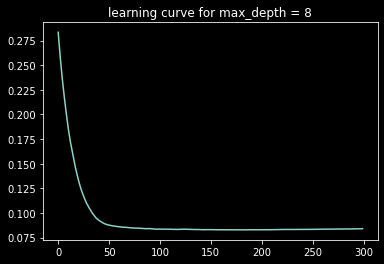

In [45]:
for msl in [20, 22, 24, 26, 28]:
    print('***** training for min_sample_leaf = {0} *****'.format(msl))
    select_params(X1_train, y1_train, X1_test, y1_test, max_estimators=300, max_depth=8, learning_rate=0.05, min_samples_leaf=msl)

Minimum Sample Leaf  of 24 computes best MAE.

### 3.5 Models Evaluation

3.5.1 Compile the selected models for evaluation

In [22]:
# create models
models_eval_hp = []
#models_eval_hp.append(('LinearRegression', lr()))
models_eval_hp.append(('Lasso', Lasso(alpha=0.001, random_state=5)))
models_eval_hp.append(('RandomForest', rfregr(random_state=5, n_estimators=400, max_depth=70, min_samples_split=10, max_features='auto', min_samples_leaf=3, bootstrap=True)))
models_eval_hp.append(('GradientBoosting', grbregr(n_estimators=300, learning_rate=0.05, max_depth=8, min_samples_split=2, min_samples_leaf=24, random_state=5)))
models_eval_hp.append(('Ridge', Ridge(alpha=1, random_state=5)))
                   
print(models_eval_hp)

[('Lasso', Lasso(alpha=0.001, random_state=5)), ('RandomForest', RandomForestRegressor(max_depth=70, min_samples_leaf=3, min_samples_split=10,
                      n_estimators=400, random_state=5)), ('GradientBoosting', GradientBoostingRegressor(learning_rate=0.05, max_depth=8, min_samples_leaf=24,
                          n_estimators=300, random_state=5)), ('Ridge', Ridge(alpha=1, random_state=5))]


3.5.2 This function is to evaluate the models using the cross validation technique on the split feature training data

 25%|██▌       | 1/4 [00:00<00:01,  1.91it/s]

Lasso: 0.086537 (0.007437)


 50%|█████     | 2/4 [00:45<00:27, 13.94s/it]

RandomForest: 0.099186 (0.006133)


100%|██████████| 4/4 [01:10<00:00, 17.73s/it]

GradientBoosting: 0.090131 (0.006795)
Ridge: 0.089059 (0.008539)


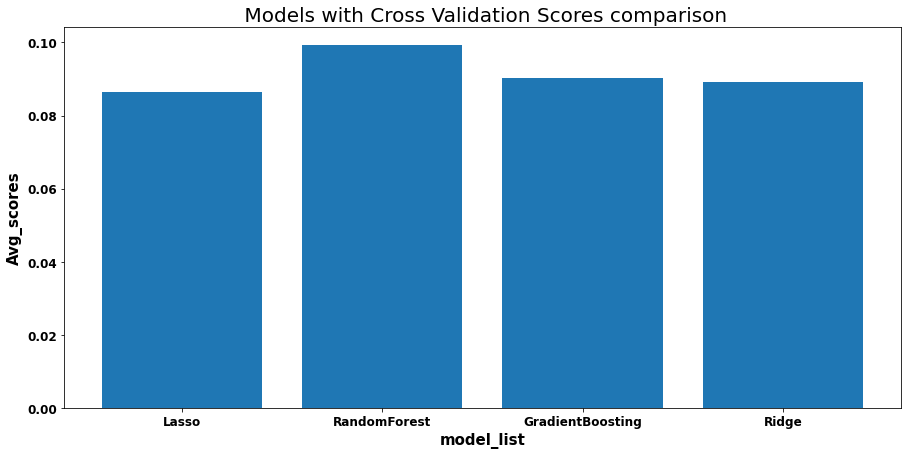

In [23]:
kfold = model(X1_train, X1_test, y1_train, y1_test)
kfold.cross_fold_val(models_eval_hp)

### 3.6 Models Testing

3.6.1 This function is to test the prediction from each model on the split feature testing data

Lasso: 0.080010
RandomForest: 0.089148
GradientBoosting: 0.082967
Ridge: 0.082026


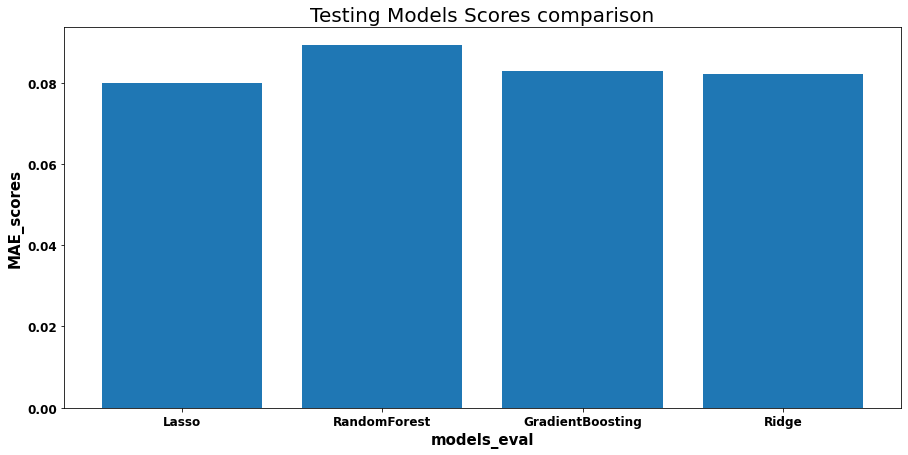

In [24]:
#Evaluate baseline models with default parameters
model_test = model(X1_train, X1_test, y1_train, y1_test)
model_test.model_run(models_eval_hp, 'Testing')

Findings :  Lasso Regression has the best MAE value of 0.080010. Hence it will be used to predict the predict the test dataset.

### 3.7 Best Model Selection

In [25]:
bestModel = Lasso(alpha=0.001, random_state=5)
bestModel

Lasso(alpha=0.001, random_state=5)

## Part 4 - DEPLOY

### 4.1 Score the Test Dataset

4.1.1 Test data was inspected cleaned and explored in section 2 above. The data will undergo same encoding and feature engineering to match the shape of the train dataset.

In [26]:
#Create a feature for Age of house using the YearBuilt & YearRemodAdd features and drop YearBuilt, YearRemodAdd, Diff
now = datetime.datetime.now()
test_df['Diff'] = test_df['YearRemodAdd'] - test_df['YearBuilt']

if ((test_df['Diff'] > 0).any()):
    house_age = now.year - test_df['YearRemodAdd']
    test_df['HouseAge'] = now.year - test_df['YearRemodAdd']
else:
    house_age = now.year - test_df['YearBuilt']
    test_df['HouseAge'] = now.year - test_df['YearBuilt']
test_df = test_df.drop(['YearBuilt', 'YearRemodAdd', 'Diff'], axis=1)

In [27]:
#Convert some features to string datatype based on their description
test_df['MSSubClass'] = test_df['MSSubClass'].astype(str)

In [28]:
# Converting some of the categorical values to numeric ones. Choosing similar values for closer groups to balance linear relations...

hood_map = {'MeadowV': 1, 'IDOTRR': 1, 'BrDale': 1, 'BrkSide': 2, 'OldTown': 2, 'Edwards': 2, 'Sawyer': 3, 'Blueste': 3, 
            'SWISU': 3, 'NPkVill': 3, 'NAmes': 3, 'Mitchel': 4, 'SawyerW': 5, 'NWAmes': 5, 'Gilbert': 5, 'Blmngtn': 5, 
            'CollgCr': 5, 'ClearCr': 6, 'Crawfor': 6, 'Veenker': 7, 'Somerst': 7, 'Timber': 8, 'StoneBr': 9, 'NridgHt': 10, 
            'NoRidge': 10}
test_df['Neighborhood'] = test_df['Neighborhood'].map(hood_map).astype('int')

exterior_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
test_df['ExterQual'] = test_df['ExterQual'].map(exterior_map).astype('int')
test_df['ExterCond'] = test_df['ExterCond'].map(exterior_map).astype('int')

bsmt_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
test_df['BsmtQual'] = test_df['BsmtQual'].map(bsmt_map).astype('int')
test_df['FireplaceQu'] = test_df['FireplaceQu'].map(bsmt_map).astype('int')
test_df['GarageCond'] = test_df['GarageCond'].map(bsmt_map).astype('int')
test_df['GarageQual'] = test_df['GarageQual'].map(bsmt_map).astype('int')
test_df['BsmtCond'] = test_df['BsmtCond'].map(bsmt_map).astype('int')

bsmtf_map = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
test_df['BsmtFinType1'] = test_df['BsmtFinType1'].map(bsmtf_map).astype('int')
test_df['BsmtFinType2'] = test_df['BsmtFinType2'].map(bsmtf_map).astype('int')

misc_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
test_df['HeatingQC'] = test_df['HeatingQC'].map(misc_map).astype('int')
test_df['KitchenQual'] = test_df['KitchenQual'].map(misc_map).astype('int')

gar_map = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3,}
test_df['GarageFinish'] = test_df['GarageFinish'].map(gar_map).astype('int')

bsmtex_map = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
test_df['BsmtExposure'] = test_df['BsmtExposure'].map(bsmtex_map).astype('int')

cair_map = {'N': 0, 'Y': 1,}
test_df['CentralAir'] = test_df['CentralAir'].map(cair_map).astype('int')

paved_map = {'N': 0, 'P': 1, 'Y': 2,}
test_df['PavedDrive'] = test_df['PavedDrive'].map(paved_map).astype('int')

poolqc_map = {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
test_df['PoolQC'] = test_df['PoolQC'].map(poolqc_map).astype('int')

In [29]:
#Extract all categorical feature ready for encoding
test_df.select_dtypes(include=['object']).columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'Foundation',
       'Heating', 'Electrical', 'Functional', 'GarageType', 'Fence',
       'MiscFeature', 'SaleType'],
      dtype='object')

In [30]:
#Extract all numerical features ready for normalization
test_df.select_dtypes(exclude=['object']).columns

Index(['LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'HouseAge'],
      dtype='object')

In [31]:
#Encode categorical features in Testing Data
cat_variables = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'Foundation',
       'Heating', 'Electrical', 'Functional', 'GarageType', 'Fence',
       'MiscFeature', 'SaleType']

for var in cat_variables:
    dummies = pd.get_dummies(test_df[var], prefix=var)
    test_df = pd.concat([test_df, dummies], axis=1)
    test_df.drop([var], axis=1, inplace=True)

In [32]:
#Normalize numerical data in Testing Dataset ready for modeling
features = ['LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'HouseAge']
test_norm = eda_process(test_df)
test_norm.normalize(features)
test_df = test_df.drop(features, axis=1)
test_df.describe()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,...,GarageQualnorm,GarageCondnorm,PavedDrivenorm,WoodDeckSFnorm,OpenPorchSFnorm,EnclosedPorchnorm,ScreenPorchnorm,PoolAreanorm,PoolQCnorm,HouseAgenorm
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,0.065113,0.000685,0.044551,0.004798,0.021247,0.372173,0.047978,0.001371,0.004112,0.098012,...,0.69791,0.561755,0.902673,0.065432,0.065113,0.023956,0.029626,0.002180,0.001885,0.519103
std,0.246810,0.026180,0.206387,0.069124,0.144258,0.483550,0.213793,0.037012,0.064018,0.297433,...,0.17722,0.141096,0.287102,0.089708,0.092835,0.066431,0.098281,0.038115,0.041881,0.301864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.75000,0.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.228571
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.75000,0.600000,1.000000,0.000000,0.037736,0.000000,0.000000,0.000000,0.000000,0.400000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.75000,0.600000,1.000000,0.117978,0.097035,0.000000,0.000000,0.000000,0.000000,0.814286
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


4.1.2 Test data encoded using funtion defined in section 4.2.1 above.

In [34]:
#Ensure training and testing data have the same number of columns
for i in list(train_df1_X):
    if i not in list(test_df):
        test_df[i] = 0

In [35]:
#Ensure training and testing data have the same number of columns
for i in list(test_df):
    if i not in list(train_df1_X):
        train_df1_X[i] = 0

In [36]:
test_df.describe()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,...,HouseStyle_2.5Fin,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,Exterior1st_ImStucc,Exterior1st_Stone,Heating_Floor,Heating_OthW,Electrical_Mix,MiscFeature_TenC
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0
mean,0.065113,0.000685,0.044551,0.004798,0.021247,0.372173,0.047978,0.001371,0.004112,0.098012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.246810,0.026180,0.206387,0.069124,0.144258,0.483550,0.213793,0.037012,0.064018,0.297433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
train_df1_X.describe()

,LotFrontagenorm,LotAreanorm,Neighborhoodnorm,OverallQualnorm,OverallCondnorm,MasVnrAreanorm,ExterQualnorm,ExterCondnorm,BsmtQualnorm,BsmtCondnorm,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,MSSubClass_150
count,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,...,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.0
mean,0.383446,0.141991,0.449243,0.609560,0.619364,0.064018,0.679092,0.616781,0.697387,0.733666,...,0.029574,0.002751,0.001376,0.006190,0.003439,0.003439,0.083219,0.002063,0.867950,0.0
std,0.112508,0.077078,0.244688,0.138115,0.123720,0.112344,0.114666,0.070347,0.175377,0.138320,...,0.169466,0.052396,0.037075,0.078459,0.058560,0.058560,0.276308,0.045392,0.338661,0.0
min,0.115385,0.018372,0.100000,0.100000,0.111111,0.000000,0.400000,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.329670,0.106503,0.300000,0.500000,0.555556,0.000000,0.600000,0.600000,0.600000,0.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
50%,0.384615,0.133668,0.500000,0.600000,0.555556,0.000000,0.600000,0.600000,0.800000,0.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,0.439560,0.163173,0.500000,0.700000,0.666667,0.102344,0.800000,0.600000,0.800000,0.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


### 4.2 Train best model selected on the entire training data

4.2.1 The best model is fitted to the entire training data 

In [38]:
#Train best model on the whole training data
bestModel.fit(train_df1_X, train_df_logY)

Lasso(alpha=0.001, random_state=5)

4.2.2 SalePrice predictions based on test data features are generated using the selected best model

In [39]:
SalePrice_predictions = bestModel.predict(test_df)
SalePrice_predictions

array([10.81801788, 11.6370274 , 11.64891373, ..., 11.81006842,
       11.74667765, 11.86012721])

4.2.3 Combine the test data 'Id' and the predicted SalePrice into a dataframe

In [40]:
#load the data exported from the EDA Notebook into a Pandas dataframe
test_df_orig = pd.read_csv("data/test.csv")

In [41]:
#Create a dataframe for the Test Data Id and the predicted SalePrice
result = pd.DataFrame({'Id' : test_df_orig.Id, 'SalePrice' : np.exp(SalePrice_predictions)})

In [42]:
result.head(20)

,Id,SalePrice
0,1461,49912.056981
1,1462,113213.127343
2,1463,114566.845130
3,1464,121688.328245
4,1465,108795.866264
5,1466,120016.575595
6,1467,107811.008577
7,1468,120272.596662
8,1469,133760.952908
9,1470,126327.791452


In [43]:
#Updating the test dataset with the additional 'predisted_salary' column
test_df_orig['SalePrice'] = (np.exp(SalePrice_predictions)).tolist()

In [44]:
test_df_orig.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,49912.056981
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,113213.127343
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,114566.845130
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,121688.328245
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,108795.866264


4.2.4 Export the final dataset to a csv file

In [45]:
#Exporting the final predicted dataset to a csv file
result.to_csv('submission.csv')

### 4.3 Feature Importance

4.3.1 Fit the Gradient Boosting Model to the coded training data to compute feature importance

In [46]:
grb = grbregr(n_estimators=300, learning_rate=0.05, max_depth=8, min_samples_split=2, min_samples_leaf=24, random_state=5)
grb.fit(train_df1_X, train_df_logY )

GradientBoostingRegressor(learning_rate=0.05, max_depth=8, min_samples_leaf=24,
                          n_estimators=300, random_state=5)

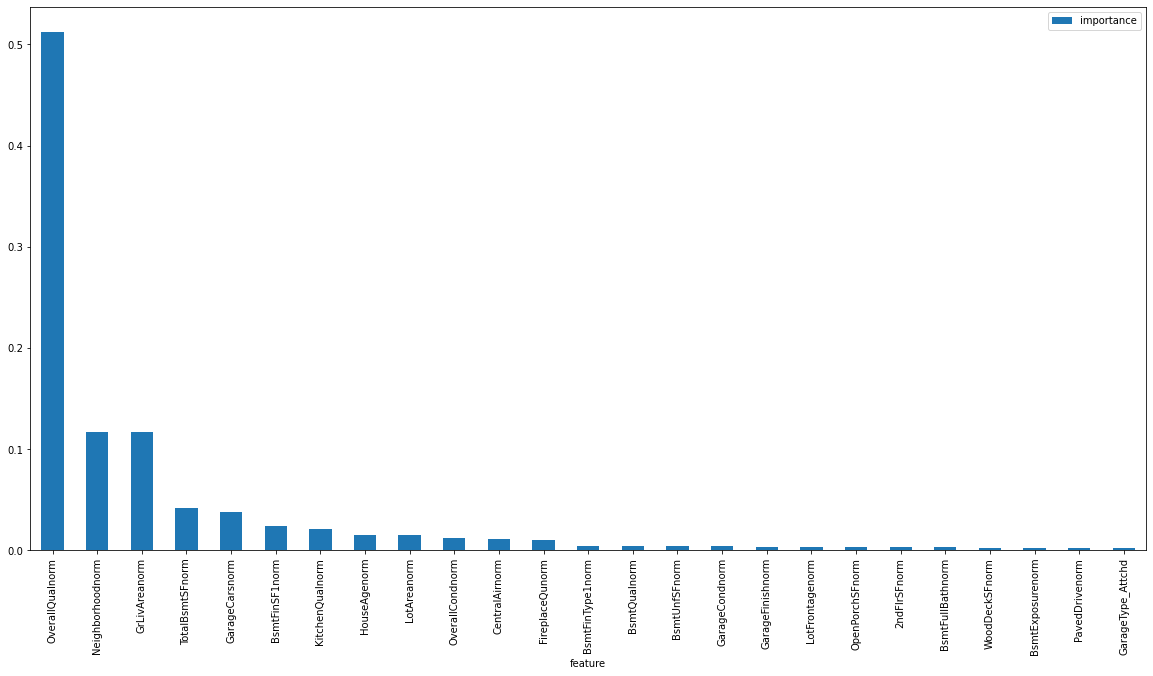

In [47]:
# store feature importances

if hasattr(grb, 'feature_importances_'):
    importances = grb.feature_importances_

else:
    # for linear models which don't have feature_importances_
    importances = [0]*len(train_df1_X.columns)

feature_importances = pd.DataFrame({'feature':train_df1_X.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    
# set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)
    
# create plot
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

Findings :  
    
1. The top 5 important features are :
   - OverallQualnorm
   - Neighborhoodnorm
   - GrLivAreanorm
   - TotalBsmtSFnorm
   - GarageCarsnorm
2. All these features have high correlation to SalePrice as discovered in the EDA section of the project.

### 4.4 Model Improvement Opportunities

1. Consider using Principal Component Regression, 
2. Consider performing log transformation on some of the independent variables
3. Explore other available models
4. Perform more EDA to identify features that can be combined to generate more direct features, for example:
   - Total number of Bedrooms 
   - Total number of Bathrooms
   - Direct feature stating pool availability or not 

### This is the conclusion of the Project. Thanks for following along.